In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
try:
    import music21
except:
    !pip install music21

# try:
#     import lilypond
# except:
#     !pip install lilypond

try: 
    from midi2audio import FluidSynth
except:
    !pip install midi2audio
    from midi2audio import FluidSynth

In [2]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
#Loading the list of chopin's midi files as stream 
filepath = "/home/cyt/Senior Semester 2/Machine Learning/Project/ML_Project_Data/bach/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Next, I get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either piano chords or piano notes. 

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes. 

**Chord:** A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

**The function to get the notes:**

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 4145


In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'C4', 'E4']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [6]:
pip install Lilypond

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement Lilypond
ERROR: No matching distribution found for Lilypond
Note: you may need to restart the kernel to use updated packages.


Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpwfw7od2l.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpwfw7od2l.ly.eps'...
Converting to PNG...
Layout output to `tmpwfw7od2l.ly-1.eps'...
Layout output to `tmpwfw7od2l.ly-2.eps'...
Layout output to `tmpwfw7od2l.ly-3.eps'...
Writing tmpwfw7od2l.ly-systems.texi...
Writing tmpwfw7od2l.ly-systems.tex...
Writing tmpwfw7od2l.ly-systems.count...
Success: compilation successfully completed


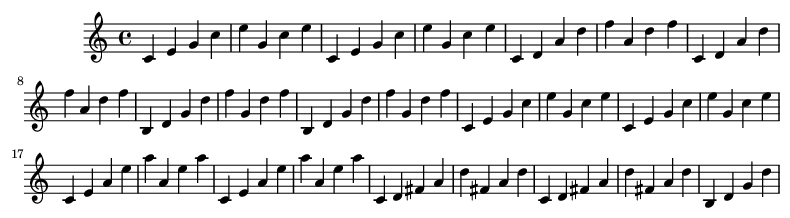

In [7]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

**Playing the above sheet music** 

*As I could not play a midi file on the Kaggle interface, I have created a ".wav" filetype of the same outside of this code. I am using it to create an audio interface. Let us have a listen to the data corpus.* 

In [8]:
#to play audio or corpus
print("Sample Audio From Data")
# IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav") 

Sample Audio From Data


**Examine all the notes in the Corpus** 

In [9]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 114


In [10]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 36.35964912280702
Most frequent note in Corpus appeared: 226 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes. 
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

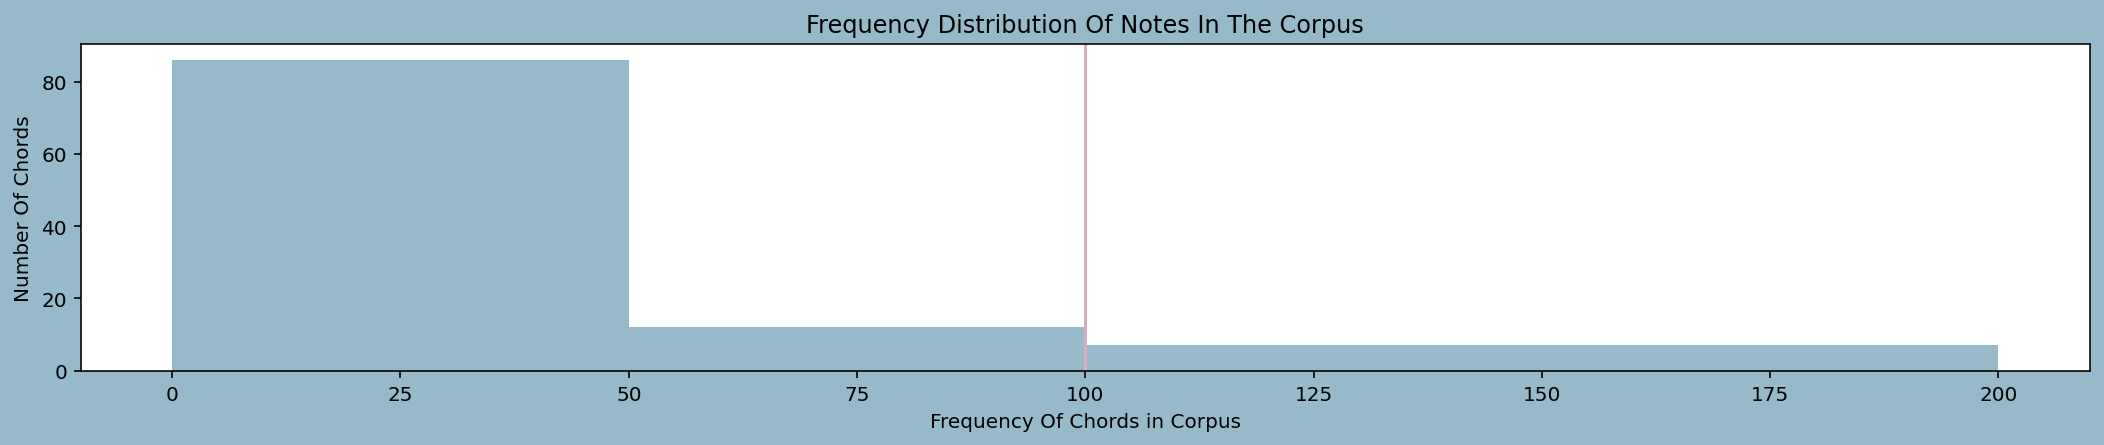

In [11]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section. 

In [12]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 98


In [13]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 2981


In [14]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 2981
Number of unique characters: 100


**Encoding and Splitting the Corpus as Labels and Targets**

In [15]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 2941


In [16]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

**Splitting Train and Seed datasets**

In [17]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(2352, 40, 1)

In [19]:
X_seed.shape

(589, 40, 1)

In [20]:
y_train.shape

(2352, 100)

In [21]:
y_seed.shape

(589, 100)

In [22]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

2022-05-17 19:13:36.401220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 19:13:36.424443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 19:13:36.424619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 19:13:36.425286: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [23]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               25700     
                                                                 
Total params: 1,931,620
Trainable params: 1,931,620
Non-

In [24]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=2000)

Epoch 1/2000


2022-05-17 19:13:40.923831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-17 19:13:41.055914: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 4s 42ms/step - loss: 4.8274
Epoch 2/2000
10/10 [==============================] - 0s 39ms/step - loss: 3.5110
Epoch 3/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4712
Epoch 4/2000
10/10 [==============================] - 0s 39ms/step - loss: 3.4617
Epoch 5/2000
10/10 [==============================] - 0s 39ms/step - loss: 3.4551
Epoch 6/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4417
Epoch 7/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4371
Epoch 8/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4432
Epoch 9/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4444
Epoch 10/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4411
Epoch 11/2000
10/10 [==============================] - 0s 39ms/step - loss: 3.4364
Epoch 12/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4313
Epoch 13/2000
10/10 [=====

Epoch 100/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4236
Epoch 101/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4194
Epoch 102/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4218
Epoch 103/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4188
Epoch 104/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4219
Epoch 105/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4199
Epoch 106/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4201
Epoch 107/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4231
Epoch 108/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4241
Epoch 109/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4265
Epoch 110/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.4278
Epoch 111/2000
10/10 [==============================] - 0s 40ms/step - loss:

10/10 [==============================] - 0s 41ms/step - loss: 1.2547
Epoch 295/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.2440
Epoch 296/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.2116
Epoch 297/2000
10/10 [==============================] - 0s 40ms/step - loss: 1.1581
Epoch 298/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.0996
Epoch 299/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.0491
Epoch 300/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.9592
Epoch 301/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.9260
Epoch 302/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.8565
Epoch 303/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.8491
Epoch 304/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.9769
Epoch 305/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.8127
Epoch 3

10/10 [==============================] - 0s 41ms/step - loss: 0.0261
Epoch 488/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.2181
Epoch 489/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.5897
Epoch 490/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.4043
Epoch 491/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.2985
Epoch 492/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.2037
Epoch 493/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.1169
Epoch 494/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0879
Epoch 495/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0618
Epoch 496/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0533
Epoch 497/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0342
Epoch 498/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0265
Epoch 4

10/10 [==============================] - 0s 41ms/step - loss: 5.1938e-04
Epoch 584/2000
10/10 [==============================] - 0s 40ms/step - loss: 5.7680e-04
Epoch 585/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.8325e-04
Epoch 586/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.8485e-04
Epoch 587/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.3761e-04
Epoch 588/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.4313e-04
Epoch 589/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.4619e-04
Epoch 590/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.2891e-04
Epoch 591/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.1105e-04
Epoch 592/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.8274e-04
Epoch 593/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.7181e-04
Epoch 594/2000
10/10 [=========================

10/10 [==============================] - 0s 41ms/step - loss: 5.9861e-04
Epoch 679/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.3353e-04
Epoch 680/2000
10/10 [==============================] - 0s 41ms/step - loss: 6.1163e-04
Epoch 681/2000
10/10 [==============================] - 0s 41ms/step - loss: 6.7623e-04
Epoch 682/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.2901e-04
Epoch 683/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.3034e-04
Epoch 684/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.7265e-04
Epoch 685/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.2058e-04
Epoch 686/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.4285e-04
Epoch 687/2000
10/10 [==============================] - 0s 41ms/step - loss: 6.0771e-04
Epoch 688/2000
10/10 [==============================] - 0s 41ms/step - loss: 6.1682e-04
Epoch 689/2000
10/10 [=========================

10/10 [==============================] - 0s 41ms/step - loss: 1.6672e-04
Epoch 866/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.0757e-04
Epoch 867/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.6726e-04
Epoch 868/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.7037e-04
Epoch 869/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.6911e-04
Epoch 870/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.5909e-04
Epoch 871/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.7095e-04
Epoch 872/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.4801e-04
Epoch 873/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.6090e-04
Epoch 874/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.5352e-04
Epoch 875/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.5994e-04
Epoch 876/2000
10/10 [=========================

10/10 [==============================] - 0s 41ms/step - loss: 3.3879e-05
Epoch 1051/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.4033e-05
Epoch 1052/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.8706e-05
Epoch 1053/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.2675e-05
Epoch 1054/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.4089e-05
Epoch 1055/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.4970e-05
Epoch 1056/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.8673e-05
Epoch 1057/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.6833e-05
Epoch 1058/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.1234e-05
Epoch 1059/2000
10/10 [==============================] - 0s 40ms/step - loss: 2.7412e-05
Epoch 1060/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.0511e-05
Epoch 1061/2000
10/10 [==============

Epoch 1143/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.0226e-04
Epoch 1144/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.9259e-04
Epoch 1145/2000
10/10 [==============================] - 0s 40ms/step - loss: 3.7030e-04
Epoch 1146/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.2270e-04
Epoch 1147/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.9911e-04
Epoch 1148/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.9895e-04
Epoch 1149/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.2560e-04
Epoch 1150/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.9947e-04
Epoch 1151/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.6062e-04
Epoch 1152/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.2461e-04
Epoch 1153/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.0583e-04
Epoch 1154/2000
10/10

10/10 [==============================] - 0s 41ms/step - loss: 6.5139e-04
Epoch 1236/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0074
Epoch 1237/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.4178e-04
Epoch 1238/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0067
Epoch 1239/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0136
Epoch 1240/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.0314
Epoch 1241/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0551
Epoch 1242/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0949
Epoch 1243/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.1564
Epoch 1244/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.1410
Epoch 1245/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.1310
Epoch 1246/2000
10/10 [==============================] - 0s 41ms/step - l

10/10 [==============================] - 0s 41ms/step - loss: 7.4024e-05
Epoch 1421/2000
10/10 [==============================] - 0s 41ms/step - loss: 7.0756e-05
Epoch 1422/2000
10/10 [==============================] - 0s 41ms/step - loss: 7.5696e-05
Epoch 1423/2000
10/10 [==============================] - 0s 41ms/step - loss: 9.0953e-05
Epoch 1424/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.0648e-04
Epoch 1425/2000
10/10 [==============================] - 0s 41ms/step - loss: 8.0244e-05
Epoch 1426/2000
10/10 [==============================] - 0s 41ms/step - loss: 7.4185e-05
Epoch 1427/2000
10/10 [==============================] - 0s 41ms/step - loss: 8.8243e-05
Epoch 1428/2000
10/10 [==============================] - 0s 41ms/step - loss: 7.7711e-05
Epoch 1429/2000
10/10 [==============================] - 0s 41ms/step - loss: 6.5387e-05
Epoch 1430/2000
10/10 [==============================] - 0s 41ms/step - loss: 6.9730e-05
Epoch 1431/2000
10/10 [==============

10/10 [==============================] - 0s 40ms/step - loss: 2.7856e-04
Epoch 1514/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.2164e-04
Epoch 1515/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.3764e-04
Epoch 1516/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.9480e-04
Epoch 1517/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.1021e-04
Epoch 1518/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.4640e-04
Epoch 1519/2000
10/10 [==============================] - 0s 41ms/step - loss: 3.1223e-04
Epoch 1520/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.0185e-04
Epoch 1521/2000
10/10 [==============================] - 0s 40ms/step - loss: 2.3325e-04
Epoch 1522/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.9689e-04
Epoch 1523/2000
10/10 [==============================] - 0s 41ms/step - loss: 2.2485e-04
Epoch 1524/2000
10/10 [==============

10/10 [==============================] - 0s 41ms/step - loss: 4.8074e-05
Epoch 1698/2000
10/10 [==============================] - 0s 41ms/step - loss: 4.1444e-05
Epoch 1699/2000
10/10 [==============================] - 0s 41ms/step - loss: 5.2665e-05
Epoch 1700/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.0060
Epoch 1701/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.0703
Epoch 1702/2000
10/10 [==============================] - 0s 42ms/step - loss: 0.0908
Epoch 1703/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.0923
Epoch 1704/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.1601
Epoch 1705/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.1122
Epoch 1706/2000
10/10 [==============================] - 0s 41ms/step - loss: 0.1091
Epoch 1707/2000
10/10 [==============================] - 0s 40ms/step - loss: 0.1057
Epoch 1708/2000
10/10 [==============================] - 0s 42ms/step

Epoch 1790/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.0720e-04
Epoch 1791/2000
10/10 [==============================] - 0s 40ms/step - loss: 1.0645e-04
Epoch 1792/2000
10/10 [==============================] - 0s 40ms/step - loss: 1.0626e-04
Epoch 1793/2000
10/10 [==============================] - 0s 41ms/step - loss: 9.0530e-05
Epoch 1794/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.1548e-04
Epoch 1795/2000
10/10 [==============================] - 0s 41ms/step - loss: 9.9950e-05
Epoch 1796/2000
10/10 [==============================] - 0s 41ms/step - loss: 9.3236e-05
Epoch 1797/2000
10/10 [==============================] - 0s 41ms/step - loss: 8.5247e-05
Epoch 1798/2000
10/10 [==============================] - 0s 41ms/step - loss: 9.0266e-05
Epoch 1799/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.0278e-04
Epoch 1800/2000
10/10 [==============================] - 0s 41ms/step - loss: 1.1231e-04
Epoch 1801/2000
10/10

10/10 [==============================] - 0s 41ms/step - loss: 3.7327e-05
Epoch 1883/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.1168e-05
Epoch 1884/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.2145e-05
Epoch 1885/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.6604e-05
Epoch 1886/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.4656e-05
Epoch 1887/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.2791e-05
Epoch 1888/2000
10/10 [==============================] - 0s 40ms/step - loss: 5.0570e-05
Epoch 1889/2000
10/10 [==============================] - 0s 40ms/step - loss: 5.1036e-05
Epoch 1890/2000
10/10 [==============================] - 0s 40ms/step - loss: 6.1196e-05
Epoch 1891/2000
10/10 [==============================] - 0s 40ms/step - loss: 4.1208e-05
Epoch 1892/2000
10/10 [==============================] - 0s 40ms/step - loss: 5.9731e-05
Epoch 1893/2000
10/10 [==============

[Text(0.5, 0, 'Epochs')]

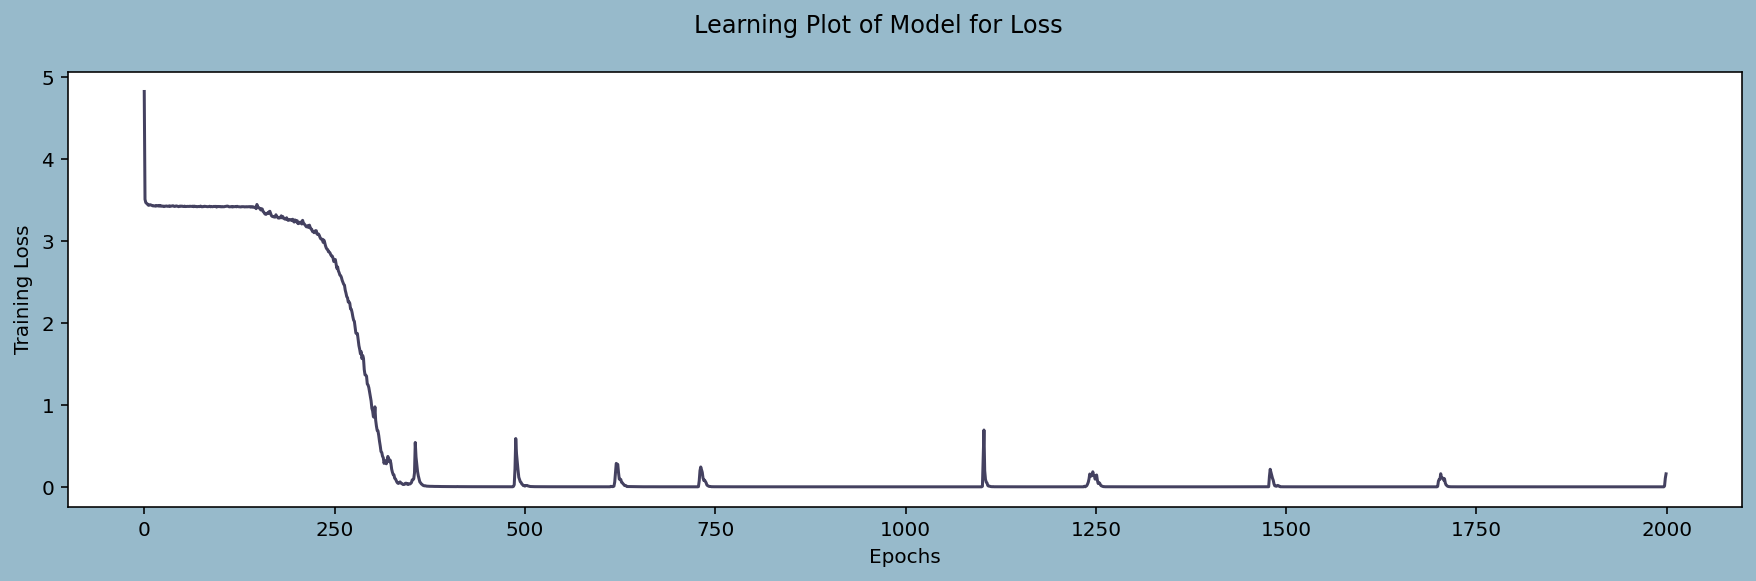

In [25]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the Melody**

A function to obtain the generated music

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpdwi0qgvs.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpdwi0qgvs.ly.eps'...
Converting to PNG...
Layout output to `tmpdwi0qgvs.ly-1.eps'...
Layout output to `tmpdwi0qgvs.ly-2.eps'...
Layout output to `tmpdwi0qgvs.ly-3.eps'...
Writing tmpdwi0qgvs.ly-systems.texi...
Writing tmpdwi0qgvs.ly-systems.tex...
Writing tmpdwi0qgvs.ly-systems.count...
Success: compilation successfully completed


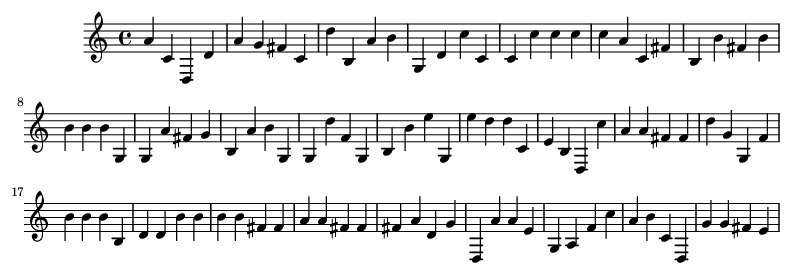

In [26]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

This sure looks like music! To check if it sounds like music we have to listen to the MIDI file. Playing midi is crumblesome. I have saved and converted a few generated melodies to ".wav" format outside of this notebook. So let us have a listen. 

**Melody Generated Sample 1**

In [27]:
new_path = '/home/cyt/Senior Semester 2/Machine Learning/Project/Algorithm/'+'Melody_Generated.mid'
fs = FluidSynth()
fs.midi_to_audio(new_path, 'new_output.wav')

ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA lib pcm

FluidSynth runtime version 2.2.7
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.



ALSA lib pcm_a52.c:1001:(_snd_pcm_a52_open) a52 is only for playback
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/cyt/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File d